## DAY3後の通し課題
今回の目的：決定木やランダムフォレストでのモデルを作成し、DAY２まで実施していたRidgeRegressionとMAEや過学習度合いなどを比較する。

ライブラリーのインポート

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import graphviz
import pydotplus
from IPython.display import Image
from sklearn.externals.six import StringIO

データの読み込み

In [69]:
df = pd.read_csv('measurements.csv',decimal=',')

In [70]:
df

,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill liters,refill gas
0,28.0,5.0,26,21.5,12,NaN,E10,0,0,0,45.0,E10
1,12.0,4.2,30,21.5,13,NaN,E10,0,0,0,NaN,NaN
2,11.2,5.5,38,21.5,15,NaN,E10,0,0,0,NaN,NaN
3,12.9,3.9,36,21.5,14,NaN,E10,0,0,0,NaN,NaN
4,18.5,4.5,46,21.5,15,NaN,E10,0,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
383,16.0,3.7,39,24.5,18,NaN,SP98,0,0,0,NaN,NaN
384,16.1,4.3,38,25.0,31,AC,SP98,1,0,0,NaN,NaN
385,16.0,3.8,45,25.0,19,NaN,SP98,0,0,0,NaN,NaN
386,15.4,4.6,42,25.0,31,AC,SP98,1,0,0,NaN,NaN


In [71]:
#精度格納用
df_precision = pd.DataFrame(index=['MAE',])
display(df_precision)

""
MAE


In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388 entries, 0 to 387
Data columns (total 12 columns):
distance         388 non-null float64
consume          388 non-null float64
speed            388 non-null int64
temp_inside      376 non-null float64
temp_outside     388 non-null int64
specials         93 non-null object
gas_type         388 non-null object
AC               388 non-null int64
rain             388 non-null int64
sun              388 non-null int64
refill liters    13 non-null float64
refill gas       13 non-null object
dtypes: float64(4), int64(5), object(3)
memory usage: 36.5+ KB


## 変数の選別
specialsはrain,sunで代用可能、refillgas,refilllittersはデータ数が少ないため削除する

In [73]:
df2=  df.drop(['specials','refill liters','refill gas'], axis=1)

In [74]:
df2

,distance,consume,speed,temp_inside,temp_outside,gas_type,AC,rain,sun
0,28.0,5.0,26,21.5,12,E10,0,0,0
1,12.0,4.2,30,21.5,13,E10,0,0,0
2,11.2,5.5,38,21.5,15,E10,0,0,0
3,12.9,3.9,36,21.5,14,E10,0,0,0
4,18.5,4.5,46,21.5,15,E10,0,0,0
...,...,...,...,...,...,...,...,...,...
383,16.0,3.7,39,24.5,18,SP98,0,0,0
384,16.1,4.3,38,25.0,31,SP98,1,0,0
385,16.0,3.8,45,25.0,19,SP98,0,0,0
386,15.4,4.6,42,25.0,31,SP98,1,0,0


## ダミー変数化
gas_tyepとrefill gasも説明変数化するためにダミー変数化する

In [75]:
#ダミー変数化
df_clm = pd.get_dummies(df2)

In [76]:
df_clm

,distance,consume,speed,temp_inside,temp_outside,AC,rain,sun,gas_type_E10,gas_type_SP98
0,28.0,5.0,26,21.5,12,0,0,0,1,0
1,12.0,4.2,30,21.5,13,0,0,0,1,0
2,11.2,5.5,38,21.5,15,0,0,0,1,0
3,12.9,3.9,36,21.5,14,0,0,0,1,0
4,18.5,4.5,46,21.5,15,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...
383,16.0,3.7,39,24.5,18,0,0,0,0,1
384,16.1,4.3,38,25.0,31,1,0,0,0,1
385,16.0,3.8,45,25.0,19,0,0,0,0,1
386,15.4,4.6,42,25.0,31,1,0,0,0,1


In [77]:
len(df_clm)

388

In [78]:
##temp_insideがNANのデータを削除
df3 = (df_clm.dropna(how='any'))
len(df3)
## in[32]で調べてtemp_insideの欠損数分デーアtが消えている事を確認
print(df3.isnull().sum())

distance         0
consume          0
speed            0
temp_inside      0
temp_outside     0
AC               0
rain             0
sun              0
gas_type_E10     0
gas_type_SP98    0
dtype: int64


## ridgeRegressionでの実装

In [11]:
##線形回帰関連のライブラリーのインポート

In [79]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split # ホールドアウト法に関する関数
from sklearn.model_selection import KFold # 交差検証法に関する関数
from sklearn.metrics import mean_absolute_error # 回帰問題における性能評価に関する関数

In [80]:
X= df3.drop(['consume'], axis=1).values
y= df3["consume"].values

In [81]:
#k-fold5で交差検証を実施
n_split = 5 # グループ数を設定（今回は5分割）

cross_valid_mae = 0
split_num = 1

# テスト役を交代させながら学習と評価を繰り返す
for train_idx, test_idx in KFold(n_splits=n_split, shuffle=True, random_state=12345).split(X, y):
    X_train, y_train = X[train_idx], y[train_idx] #学習用データ
    X_test, y_test = X[test_idx], y[test_idx]     #テスト用データ
    
    # 学習用データを使って線形回帰モデルを学習
    regr = LinearRegression(fit_intercept=True)
    regr.fit(X_train, y_train)

    # テストデータに対する予測を実行
    y_pred_test = regr.predict(X_test)
    
    # テストデータに対するMAEを計算
    mae = mean_absolute_error(y_test, y_pred_test)
    print("Fold %s"%split_num)
    print("MAE = %s"%round(mae, 3))
    print()
    
    cross_valid_mae += mae #後で平均を取るためにMAEを加算
    split_num += 1

# MAEの平均値を最終的な汎化誤差値とする
final_mae = cross_valid_mae / n_split

print("Cross Validation MAE = %s"%round(final_mae, 3))


Fold 1
MAE = 0.5

Fold 2
MAE = 0.593

Fold 3
MAE = 0.729

Fold 4
MAE = 0.686

Fold 5
MAE = 0.668

Cross Validation MAE = 0.635


## 過学習の兆候確認
グラフをみるとテストデータと訓練データで傾向は違うことから過学習は発生していないと思われる。
ただし、どちらとも実績が大きなデータが予測できていないため、最終発表に向けては工夫が必要

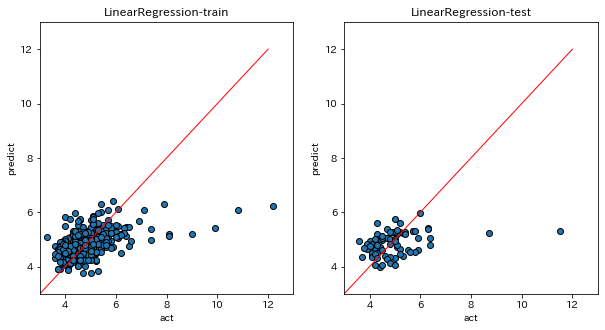

In [82]:
#学習データの実測値と予測値
y_pred_train = regr.predict(X_train)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(y_train, y_pred_train,edgecolors='black')
plt.xlabel('act')
plt.ylabel('predict')
plt.xlim(3,13)
plt.ylim(3,13)
plt.title('LinearRegression-train')
x=range(0,13,1)
y=x
plt.plot(x,y,"r-",linewidth=1.0,color='red')


#テストデータの実測値と予測値
plt.subplot(1,2,2)
plt.scatter(y_test, y_pred_test,edgecolors='black')
plt.xlabel('act')
plt.ylabel('predict')
plt.xlim(3,13)
plt.ylim(3,13)
plt.title('LinearRegression-test')
x=range(0,13,1)
y=x
plt.plot(x,y,"r-",linewidth=1.0,color='red')
plt.show()

In [83]:
#精度格納
df_precision['重回帰'] = [round(final_mae, 3)]
df_precision

,重回帰
MAE,0.635


In [84]:
# nullを調べる
print(df_clm.isnull().sum())
#In[37]でtemp_inside nullを削除

distance          0
consume           0
speed             0
temp_inside      12
temp_outside      0
AC                0
rain              0
sun               0
gas_type_E10      0
gas_type_SP98     0
dtype: int64


## 決定木によるモデル作成

In [102]:
from sklearn.tree import DecisionTreeRegressor, export_graphviz
X= df3.drop(['consume'], axis=1).values
y= df3["consume"].values


In [56]:
##from sklearn.model_selection import train_test_split 
##X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [103]:
#k-fold5で交差検証を実施
n_split = 5 # グループ数を設定（今回は5分割）

DTcross_valid_mae = 0
split_num = 1

# テスト役を交代させながら学習と評価を繰り返す
for train_idx, test_idx in KFold(n_splits=n_split, shuffle=True, random_state=12345).split(X, y):
    X_train, y_train = X[train_idx], y[train_idx] #学習用データ
    X_test, y_test = X[test_idx], y[test_idx]     #テスト用データ
    
    # 学習用データを使って線形回帰モデルを学習
    DTregr = DecisionTreeRegressor(criterion="mae", max_depth=4, min_samples_split=3, min_samples_leaf=3, random_state=1234)
    DTregr.fit(X_train, y_train)

    # テストデータに対する予測を実行
    y_pred_test = DTregr.predict(X_test)
    
    # テストデータに対するMAEを計算
    mae = mean_absolute_error(y_test, y_pred_test)
    print("Fold %s"%split_num)
    print("MAE = %s"%round(mae, 3))
    print()
    
    DTcross_valid_mae += mae #後で平均を取るためにMAEを加算
    split_num += 1

# MAEの平均値を最終的な汎化誤差値とする
DTregr_mae = DTcross_valid_mae / n_split
print("Cross Validation MAE = %s"%round(DTregr_mae, 3))


Fold 1
MAE = 0.442

Fold 2
MAE = 0.536

Fold 3
MAE = 0.579

Fold 4
MAE = 0.463

Fold 5
MAE = 0.463

Cross Validation MAE = 0.497


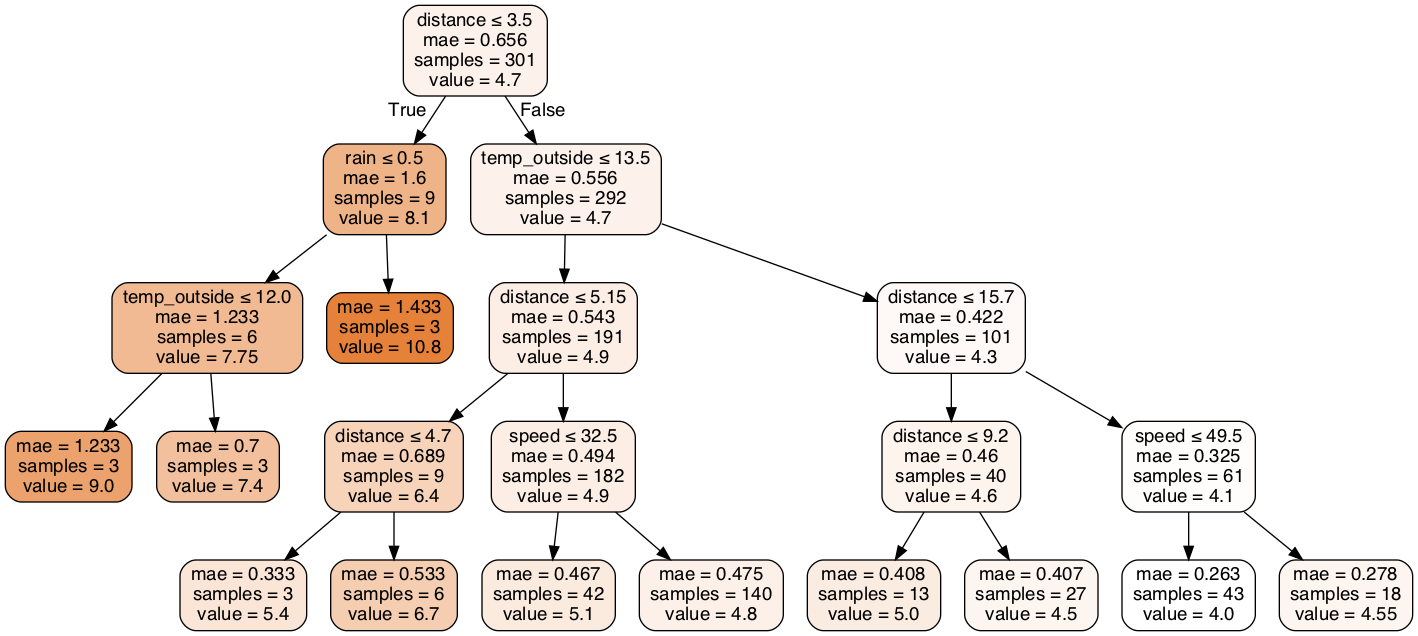

In [104]:
# 決定木の描画
dot_data = StringIO() #dotファイル情報の格納先

export_graphviz(DTregr, out_file=dot_data,  
feature_names=["distance","speed","temp_inside","temp_outside","AC","rain","sun","gas_type_E10","gas_type_SP98"],  
class_names=["cosume"],  
filled=True, rounded=True,  
special_characters=True) 
graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
Image(graph.create_png())


In [105]:
#精度格納
df_precision['決定木'] = [round(DTregr_mae, 3)]
df_precision

,重回帰,決定木
MAE,0.635,0.497


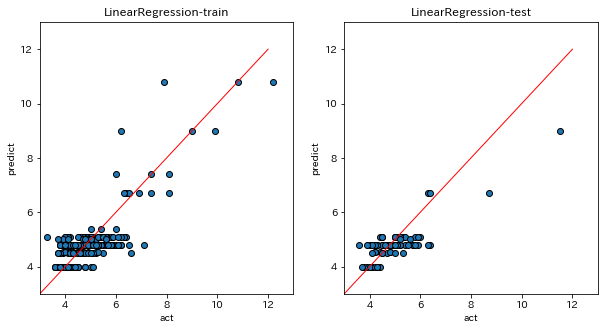

In [106]:
#学習データの実測値と予測値
y_pred_train = DTregr.predict(X_train)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(y_train, y_pred_train,edgecolors='black')
plt.xlabel('act')
plt.ylabel('predict')
plt.xlim(3,13)
plt.ylim(3,13)
plt.title('LinearRegression-train')
x=range(0,13,1)
y=x
plt.plot(x,y,"r-",linewidth=1.0,color='red')


#テストデータの実測値と予測値
plt.subplot(1,2,2)
plt.scatter(y_test, y_pred_test,edgecolors='black')
plt.xlabel('act')
plt.ylabel('predict')
plt.xlim(3,13)
plt.ylim(3,13)
plt.title('LinearRegression-test')
x=range(0,13,1)
y=x
plt.plot(x,y,"r-",linewidth=1.0,color='red')
plt.show()

## RandomForestでもやってみる
#ハイパーパラメータはDTと同じものを一旦使用
RandomeForestはK-foldする必要があるかわからない（特徴量を選択するため、交差検証みたいになっている？）

In [109]:
from sklearn.ensemble import RandomForestRegressor



RFregr = RandomForestRegressor(n_estimators=10, max_depth=4, criterion="mae",
                                                 min_samples_leaf=3, min_samples_split=3, random_state=1234)
RFregr.fit(X_train, y_train)
print("score=", RFregr.score(X_train, y_train))

# 説明変数の重要度を出力する
# scikit-learnで算出される重要度は、ある説明変数による不純度の減少量合計である。
print(RFregr.feature_importances_)


score= 0.6842494941811017
[0.50984749 0.15323552 0.04050541 0.2360441  0.01029827 0.03185788
 0.01013825 0.00432692 0.00374615]


0


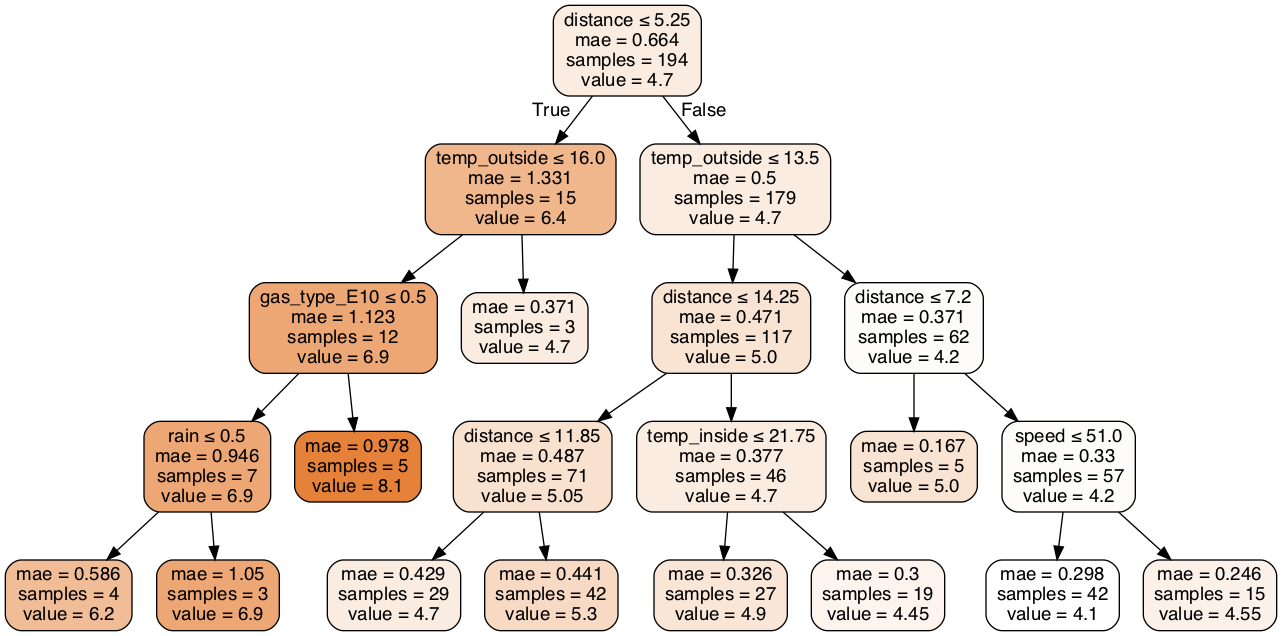

1


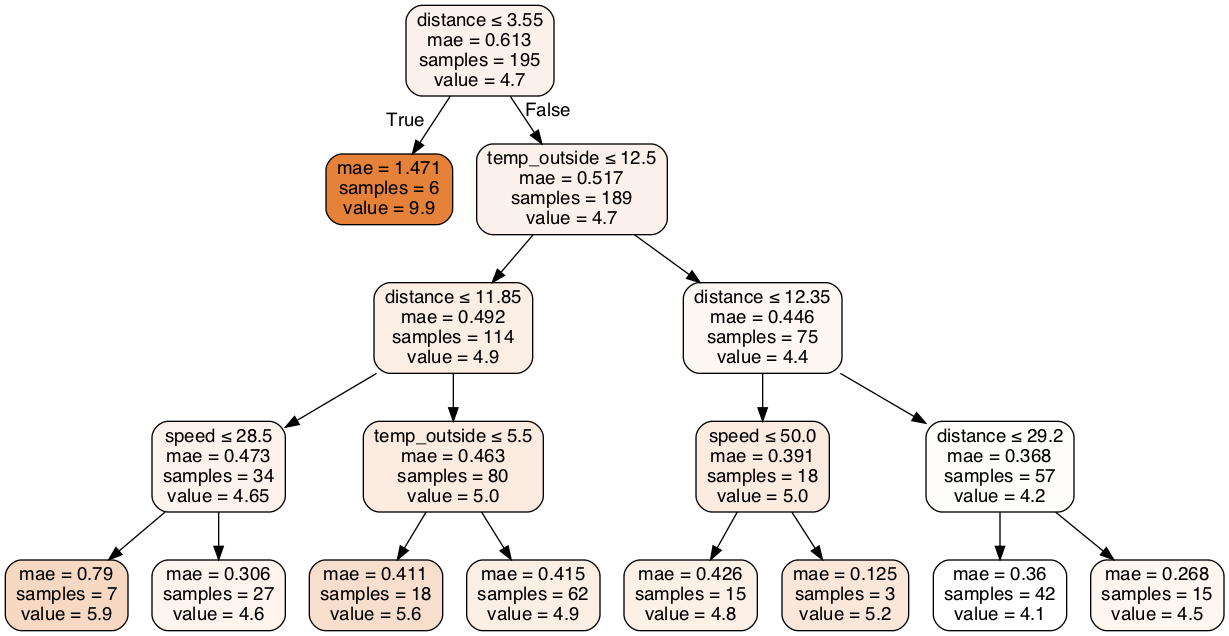

2


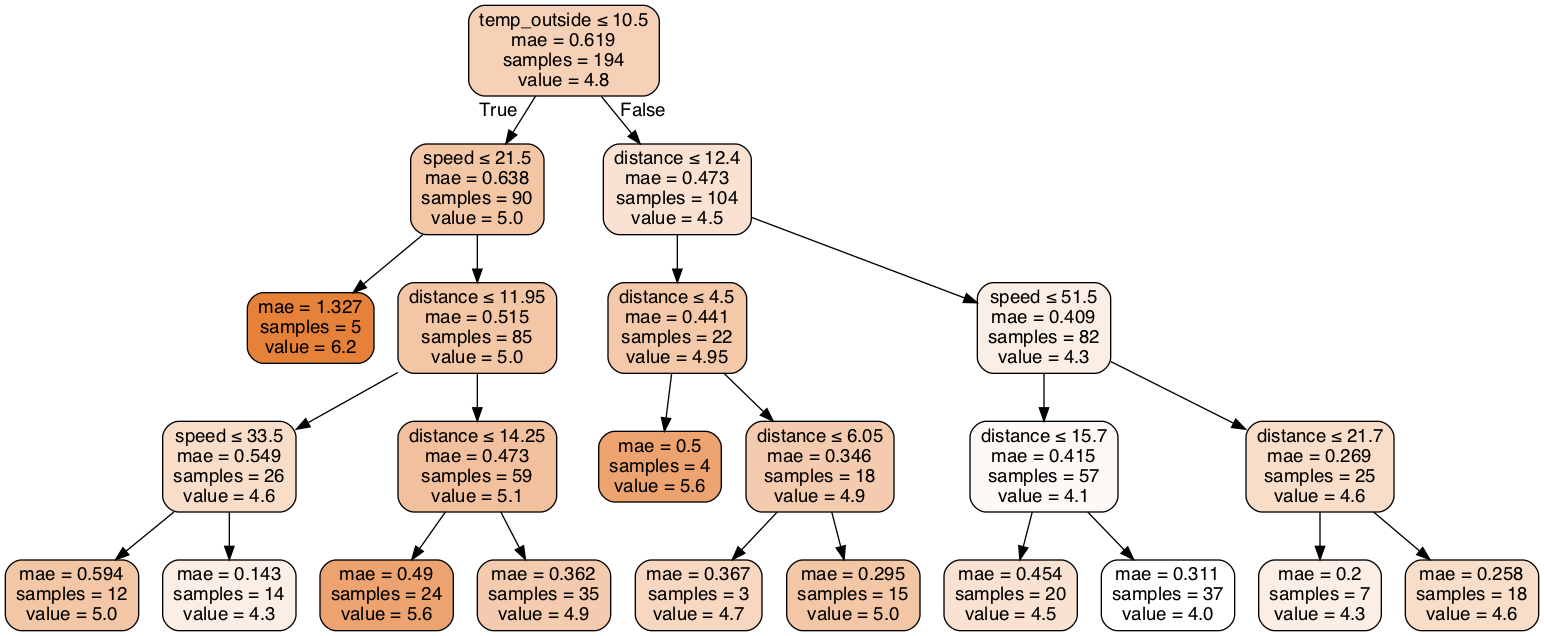

3


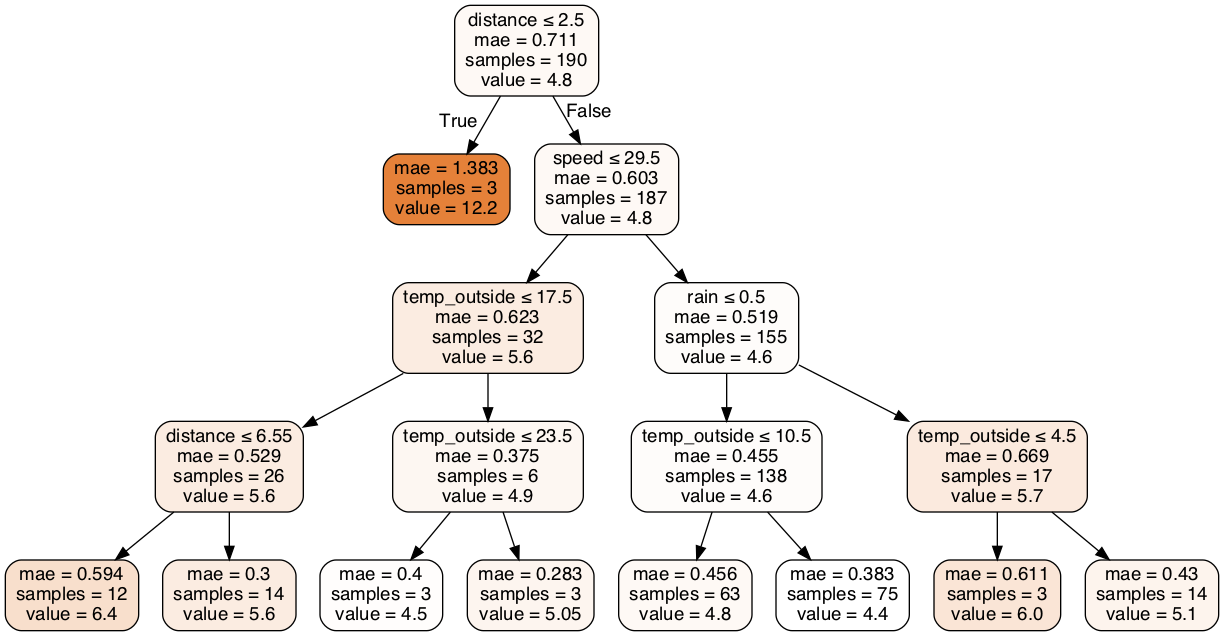

4


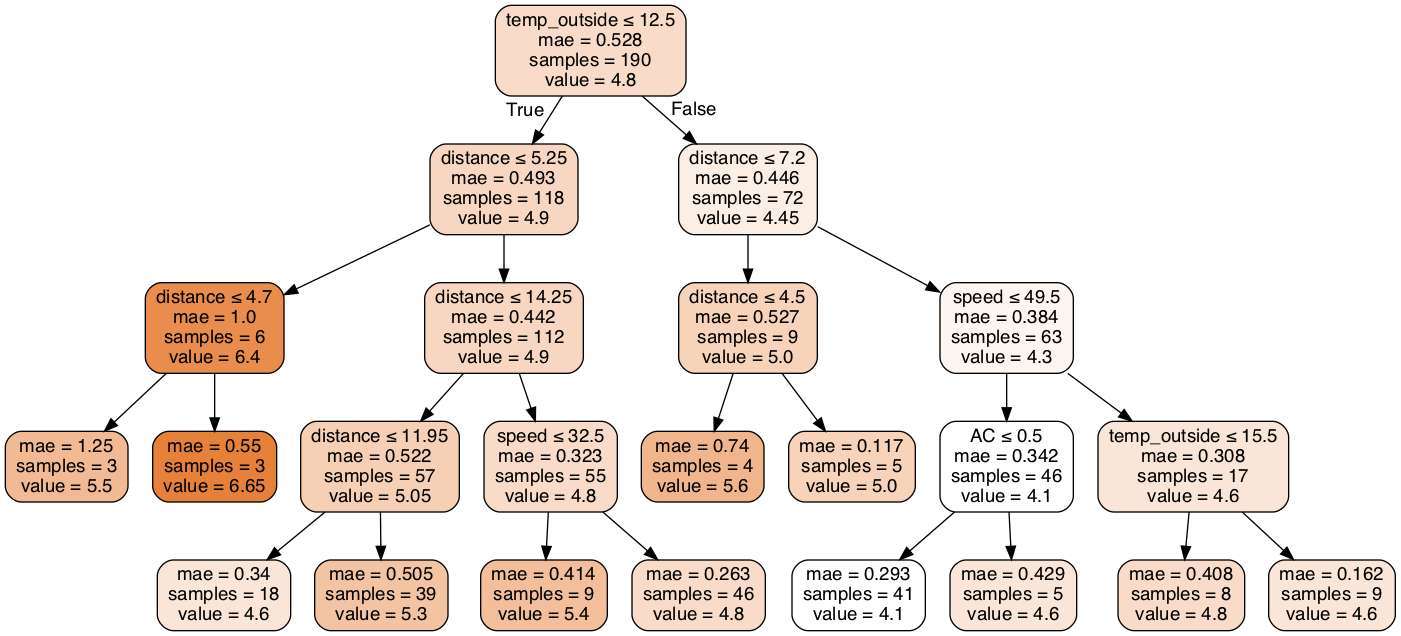

5


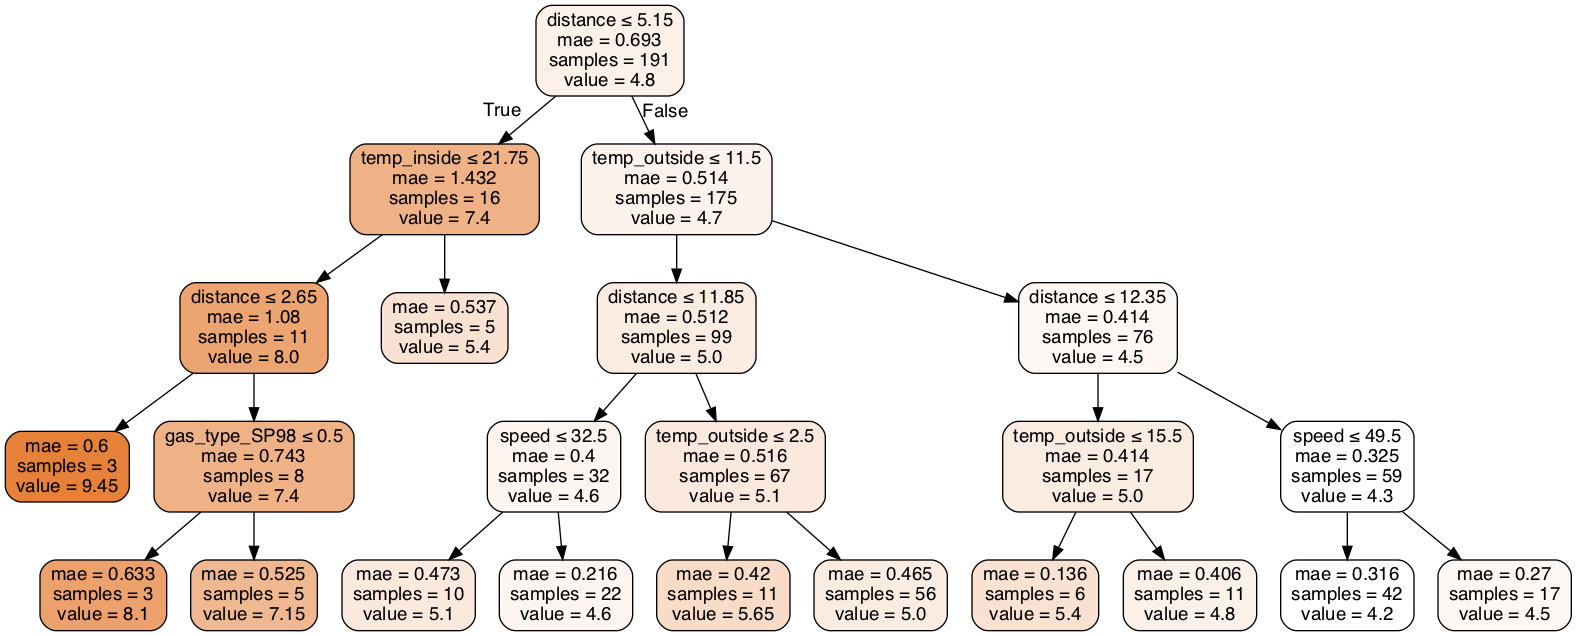

6


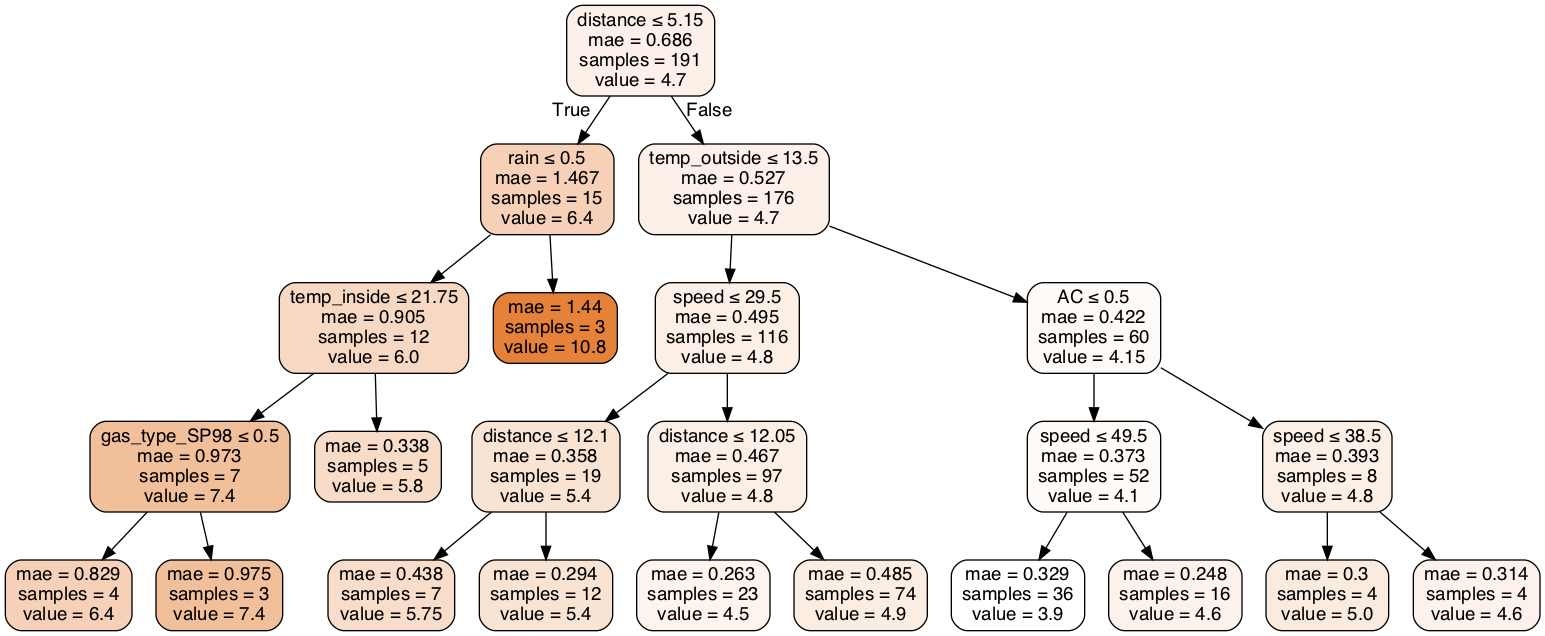

7


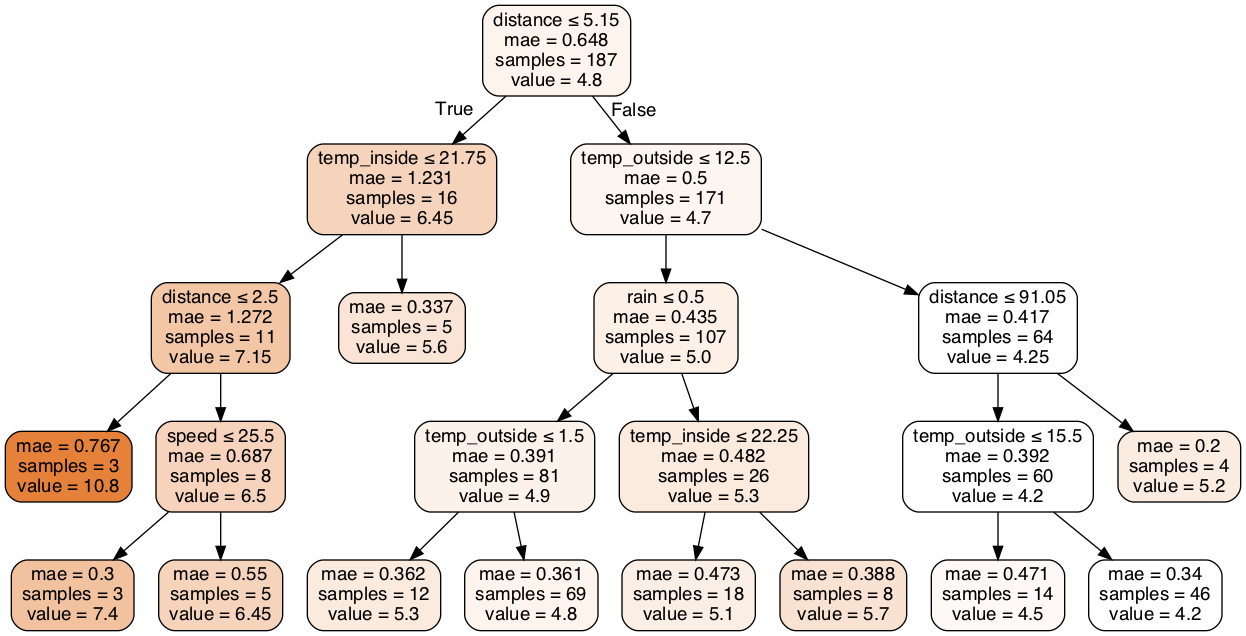

8


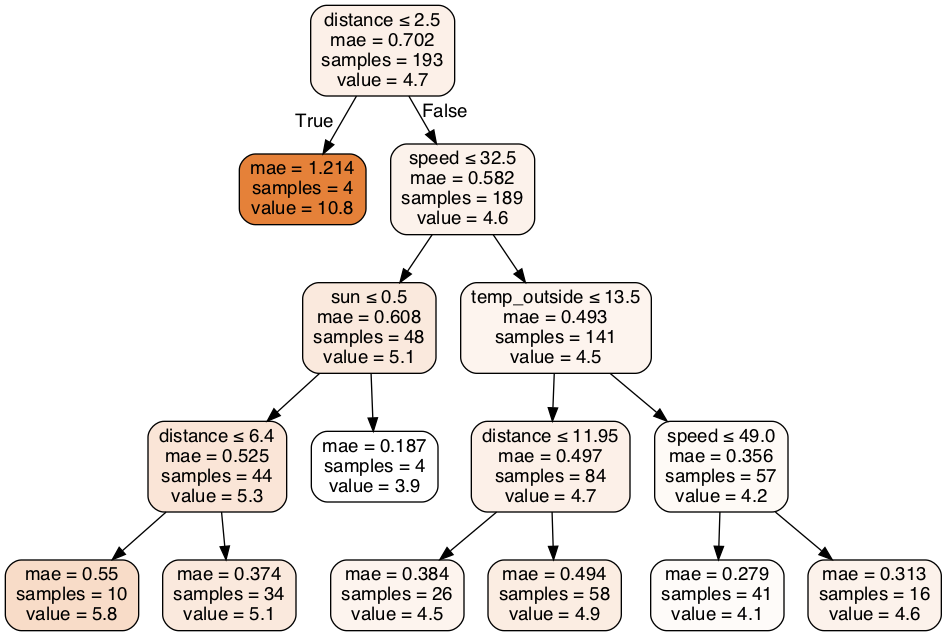

9


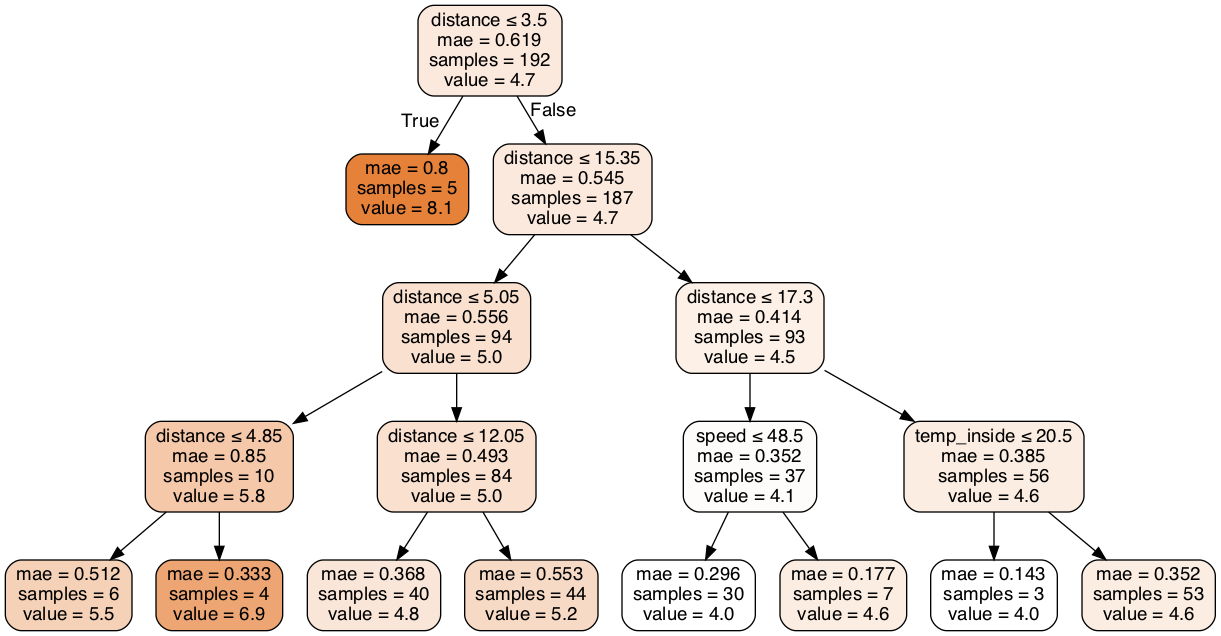

In [110]:
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image
from sklearn.externals.six import StringIO

for i, est in enumerate(RFregr.estimators_):
    print(i)
    
    # 決定木の描画
    dot_data = StringIO() #dotファイル情報の格納先
    export_graphviz(est, out_file=dot_data,  
                    feature_names=["distance","speed","temp_inside","temp_outside","AC","rain","sun","gas_type_E10","gas_type_SP98"],
                         class_names=["consume"],  
                         filled=True, rounded=True,  
                         special_characters=True) 
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
    display(Image(graph.create_png()))

In [113]:
# テストデータに対する予測を実行
y_pred_test = regr.predict(X_test)
mae = mean_absolute_error(y_test, y_pred_test)
print("MAE = %s"%round(mae, 3))

MAE = 0.463


In [36]:
feature_names=["distance","speed","temp_inside","temp_outside","AC","rain","sun","gas_type_E10","gas_type_SP98"]
feature = pd.DataFrame({"true":feature_names, "重要度":RFregr.feature_importances_})
print(feature)

            true       重要度
0       distance  0.537670
1          speed  0.102430
2    temp_inside  0.038224
3   temp_outside  0.290313
4             AC  0.000000
5           rain  0.031362
6            sun  0.000000
7   gas_type_E10  0.000000
8  gas_type_SP98  0.000000


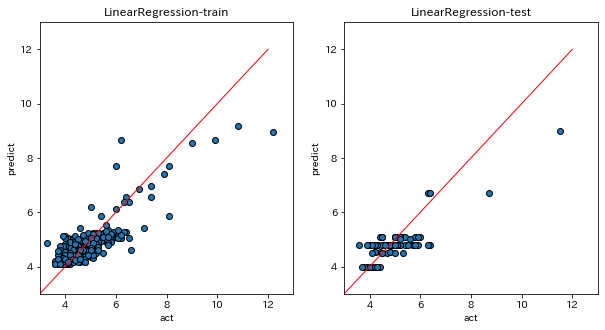

In [116]:
#学習データの実測値と予測値
y_pred_train = RFregr.predict(X_train)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(y_train, y_pred_train,edgecolors='black')
plt.xlabel('act')
plt.ylabel('predict')
plt.xlim(3,13)
plt.ylim(3,13)
plt.title('LinearRegression-train')
x=range(0,13,1)
y=x
plt.plot(x,y,"r-",linewidth=1.0,color='red')


#テストデータの実測値と予測値
plt.subplot(1,2,2)
plt.scatter(y_test, y_pred_test,edgecolors='black')
plt.xlabel('act')
plt.ylabel('predict')
plt.xlim(3,13)
plt.ylim(3,13)
plt.title('LinearRegression-test')
x=range(0,13,1)
y=x
plt.plot(x,y,"r-",linewidth=1.0,color='red')
plt.show()

In [114]:
#精度格納
df_precision['RF'] = [round(mae, 3)]
df_precision

,重回帰,決定木,RF
MAE,0.635,0.497,0.463


## 精度比較

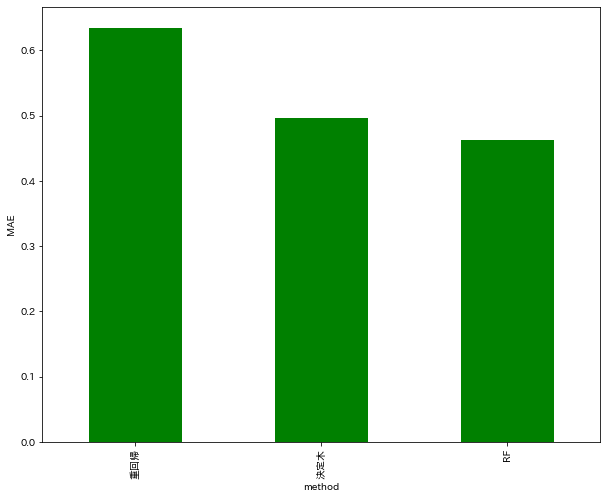

In [115]:
df_precision.T['MAE'].plot.bar(figsize=(10,8),color='g')
plt.xlabel('method')
plt.ylabel('MAE')
plt.title('')
plt.show()

精度をみるとRFが一番精度がよくなる。過学習も発生していないことからハイパーパラメータの調整をしてより良い精度を出せるようようにする